# import packages

In [14]:
import tensorflow as tf
import tensorflow.keras.layers as tkl
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from keras.regularizers import l2
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom, CenterCrop, RandomContrast
from tensorflow.keras.metrics import AUC
import numpy as np
import sklearn.metrics
import tensorflow.keras.backend as kbe
from keras import backend as K

**run only once**

In [15]:
#!unzip  "/content/drive/MyDrive/AI/fashion.zip" -d "/content/drive/MyDrive/AI/"

In [46]:
BATCH_SIZE = 128
IMG_SIZE = (32, 32)
training_directory = "../Datasets/work/fashion/train"
valid_directory = "../Datasets/work/fashion/valid"

train_dataset = image_dataset_from_directory(training_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             seed=42)
validation_dataset = image_dataset_from_directory(valid_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             seed=42)

Found 19980 files belonging to 2 classes.
Found 830 files belonging to 2 classes.


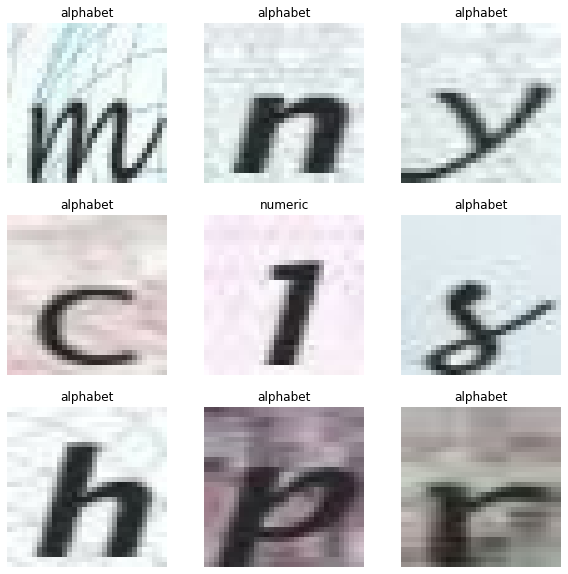

In [47]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(3, 12):
        ax = plt.subplot(3, 3, i - 2)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [48]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential() 
    data_augmentation.add(RandomContrast(0.3))
    #data_augmentation.add(RandomZoom((0, 0.)))
    
    
    return data_augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


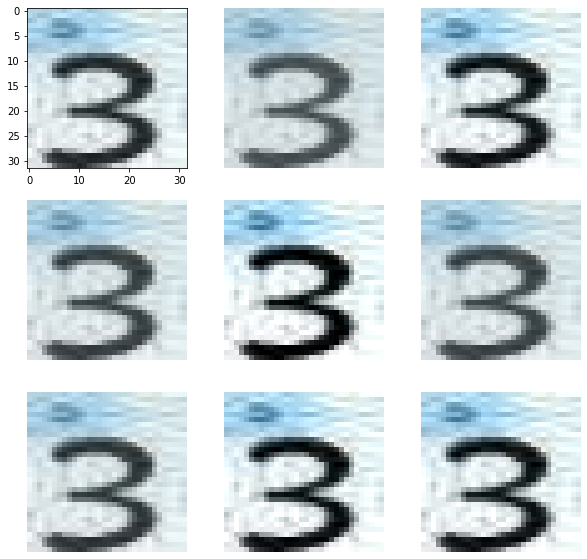

In [49]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    
    first_image = image[0]
    #print(type(first_image))
    plt.subplot(3, 3, 1)
    plt.imshow(first_image/255)
    for i in range(8):
        ax = plt.subplot(3, 3, i + 2)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [118]:
def block_c(x, power, last_filters):
    batch, input_height, input_width, input_channels = x.shape
    #print(f'input_c:{x.shape}')
    x = tkl.Conv2D(power*input_channels, (1, 1), padding='same')(x)
    #x = tkl.Dropout(0.1)(x)
    #print(f'1st_conv_c:{x.shape}')
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    x = tkl.ReLU(max_value=6)(x)
    x = tkl.DepthwiseConv2D((3, 3), strides=(2, 2),padding='same')(x)
    #x = tkl.Dropout(0.1)(x)
    #print(f'1st_depth_c:{x.shape}')
    #x = tkl.BatchNormalization(axis=3)(x, training=True)
    x = tkl.ReLU(max_value=6)(x)
    x = tkl.Conv2D(last_filters, (1, 1), padding='same')(x)
    #x = tkl.Dropout(0.3)(x)
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    #print(f'2nd_conv_c:{x.shape}')
    return x

In [228]:
def block_b(x, power, last_filters):
    batch, input_height, input_width, input_channels = x.shape
    #print(f'input_b:{x.shape}')
    
    x = tkl.Conv2D(power*input_channels, (1, 1), padding='same')(x)
    #x = tkl.Dropout(0.2)(x)
    #x = tkl.Dropout(0.1)(x)
    #print(f'1st_conv_b:{x.shape}')
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    x = tkl.ReLU(max_value=6)(x)
    x = tkl.DepthwiseConv2D((3, 3), padding='same')(x)
    #x = tkl.Dropout(0.1)(x)
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    #print(f'1st_depth_b:{x.shape}')
    x = tkl.ReLU(max_value=6)(x)
    x = tkl.Conv2D(last_filters, (1, 1), padding='same')(x)
    x = tkl.Dropout(0.3)(x)
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    #print(f'2nd_conv_b:{x.shape}')
    return x

In [229]:
def block_a(x, power, last_filters):
    batch, input_height, input_width, input_channels = x.shape
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    input_x = x
    #print(f'input_a:{x.shape}')
    x = tkl.Conv2D(power*input_channels, (1, 1), padding='same')(x)
    #x = tkl.Dropout(0.1)(x)
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    #print(f'1st_conv_a:{x.shape}')
    x = tkl.ReLU(max_value=6)(x)
    x = tkl.DepthwiseConv2D((3, 3), padding='same')(x)
    #x = tkl.Dropout(0.1)(x)
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    #print(f'1st_depth_a:{x.shape}')
    x = tkl.ReLU(max_value=6)(x)
    x = tkl.Conv2D(last_filters, (1, 1), padding='same')(x)
    #x = tkl.Dropout(0.3)(x)
    
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    #print(f'2nd_conv_a:{x.shape}')
    x = tkl.Add()([x, input_x])
    #print(f'add_a:{x.shape}')
    return x

In [230]:
def conv_model(input_shape=(32, 32, 3)):
    x_input = Input(shape=input_shape)
    #print(f'input:{x_input.shape}')
    x = data_augmenter()(x_input)
    x = tkl.Conv2D(8, (3, 3), strides=(2, 2),padding='same')(x)
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    #print(f'1st_conv:{x.shape}')
    x = block_c(x, 1, 8)
    x = block_c(x, 2, 16)
    x = block_a(x, 2, 16)
    x = block_c(x, 2, 24)
    x = block_a(x, 2, 24)
    x = block_b(x, 2, 32)
    x = tkl.Flatten()(x)
    x = tkl.Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=0))(x)
    model = Model(inputs=x_input, outputs=x)
    return model

In [231]:
model = conv_model(input_shape = (32, 32, 3))
print(model.summary())

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential_9 (Sequential)      (None, 32, 32, 3)    0           ['input_24[0][0]']               
                                                                                                  
 conv2d_299 (Conv2D)            (None, 16, 16, 8)    224         ['sequential_9[0][0]']           
                                                                                                  
 batch_normalization_303 (Batch  (None, 16, 16, 8)   32          ['conv2d_299[0][0]']             
 Normalization)                                                                            

In [232]:
def equal_error_rate(y_true, y_pred):
    n_imp = tf.math.count_nonzero(tf.equal(y_true, 0), dtype=tf.float32) + tf.constant(K.epsilon())
    n_gen = tf.math.count_nonzero(tf.equal(y_true, 1), dtype=tf.float32) + tf.constant(K.epsilon())

    scores_imp = tf.boolean_mask(y_pred, tf.equal(y_true, 0))
    scores_gen = tf.boolean_mask(y_pred, tf.equal(y_true, 1))

    loop_vars = (tf.constant(0.0), tf.constant(1.0), tf.constant(0.0))
    cond = lambda t, fpr, fnr: tf.greater_equal(fpr, fnr)
    body = lambda t, fpr, fnr: (
        t + 0.001,
        tf.divide(tf.math.count_nonzero(tf.greater_equal(scores_imp, t), dtype=tf.float32), n_imp),
        tf.divide(tf.math.count_nonzero(tf.less(scores_gen, t), dtype=tf.float32), n_gen)
    )
    t, fpr, fnr = tf.while_loop(cond, body, loop_vars, back_prop=False)
    eer = (fpr + fnr) / 2

    return eer

In [233]:
base_learning_rate = 0.1
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [234]:
initial_epochs = 25
checkpoint_filepath = 'tmp/checkpoint_alpha=0.1_bn_aug(rc)_do(1)'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor= 'val_accuracy',mode='max', save_best_only=True)
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=model_checkpoint_callback)

Epoch 1/25
157/157 [==============================] - 11s 57ms/step - loss: 0.0968 - accuracy: 0.9730 - val_loss: 0.4514 - val_accuracy: 0.8723
Epoch 2/25
157/157 [==============================] - 13s 82ms/step - loss: 0.0262 - accuracy: 0.9921 - val_loss: 0.2582 - val_accuracy: 0.9084
Epoch 3/25
157/157 [==============================] - 10s 62ms/step - loss: 0.0166 - accuracy: 0.9948 - val_loss: 0.3699 - val_accuracy: 0.9434
Epoch 4/25
157/157 [==============================] - 9s 57ms/step - loss: 0.0158 - accuracy: 0.9952 - val_loss: 0.8169 - val_accuracy: 0.8892
Epoch 5/25
157/157 [==============================] - 9s 53ms/step - loss: 0.0420 - accuracy: 0.9869 - val_loss: 0.3502 - val_accuracy: 0.9217
Epoch 6/25
157/157 [==============================] - 8s 51ms/step - loss: 0.0218 - accuracy: 0.9938 - val_loss: 0.4462 - val_accuracy: 0.9422
Epoch 7/25
157/157 [==============================] - 8s 48ms/step - loss: 0.0161 - accuracy: 0.9952 - val_loss: 0.9133 - val_accuracy: 0.9

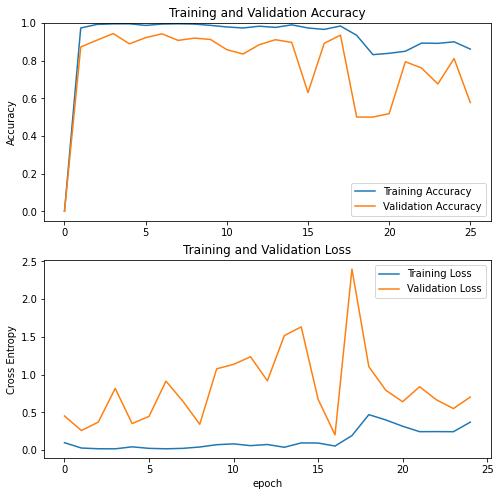

In [235]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
eer = [0.] + history.history['equal_error_rate']
val_eer = [0.] + history.history['val_equal_error_rate']

plt.figure(figsize=(8, 8))
plt.plot(eer, label='Training Equal Error Rate')
plt.plot(val_eer, label='Validation Equal Error Rate')
plt.legend(loc='lower right')
plt.ylabel('Equal Error Rate')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Equal Error Rate')
plt.show()

In [237]:
max(history.history['val_accuracy'])

0.9433735013008118

In [173]:
class_names

['alphabet', 'numeric']

In [239]:
checkpoint_filepath = 'tmp/checkpoint_alpha=0.1_bn_aug(rc)_do(1)'
model.load_weights(checkpoint_filepath)

In [240]:
numpy_images = np.zeros([830, 32, 32, 3])
numpy_labels = np.zeros([830, 1])
k = 0

for images, labels in validation_dataset.take(np.floor(830/BATCH_SIZE) + 1):
    images_n = images.numpy()
    labels_n = labels.numpy()
    for i in range(labels_n.shape[0]):
        numpy_labels[i + k*BATCH_SIZE] = labels_n[i]
        numpy_images[i + k*BATCH_SIZE, :, :, :] = images_n[i]
    k = k + 1

numpy_labels_pred = model.predict(numpy_images)

In [243]:
numpy_images = np.zeros([19980, 32, 32, 3])
numpy_labels = np.zeros([19980, 1])
k = 0

for images, labels in validation_dataset.take(np.floor(19980/BATCH_SIZE) + 1):
    images_n = images.numpy()
    labels_n = labels.numpy()
    for i in range(labels_n.shape[0]):
        numpy_labels[i + k*BATCH_SIZE] = labels_n[i]
        numpy_images[i + k*BATCH_SIZE, :, :, :] = images_n[i]
    k = k + 1

numpy_labels_pred = model.predict(numpy_images)

In [176]:
def compute_eer(numpy_labels, numpy_labels_pred, positive_label=1):



    # all fpr, tpr, fnr, fnr, threshold are lists (in the format of np.array)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(numpy_labels, numpy_labels_pred, pos_label=positive_label)
    fnr = 1 - tpr

    # the threshold of fnr == fpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    # theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    # return the mean of eer from fpr and from fnr
    eer = kbe.sum(eer_1/2 + eer_2/2)
    #eer = kbe.floatx()
    return eer

In [244]:
compute_eer(numpy_labels, numpy_labels_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.004402994035944461>

In [245]:
equal_error_rate(numpy_labels, numpy_labels_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.02217231>